# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
import random
import os
import glob
import shutil
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

In [2]:
test_img = glob.glob('C:/Users/Downloads/COVID19_X-Ray/Resources/Dataset/Test/**/*.jpeg')
train_img = glob.glob('C:/Users/Downloads/COVID19_X-Ray/Resources/Dataset/Train/**/*.jpeg')
val_img = glob.glob('C:/Users/Downloads/COVID19_X-Ray/Resources/Dataset/Validation/**/*.jpeg')
print(f"Number of Images in Testing Set: {len(test_img)} ")
print(f"Number of Images in Training Set: {len(train_img)} ")
print(f"Number of Images in Validation Set: {len(val_img)} ")

Number of Images in Testing Set: 44 
Number of Images in Training Set: 196 
Number of Images in Validation Set: 18 


In [3]:
DIR = "C:/Users/Downloads/COVID19_X-Ray/Resources/Dataset/"
sets = ["Test", "Train", "Validation"]
covid_imgs = []
normal_imgs = []
for cat in sets:
    path = os.path.join(DIR, cat)
    noncov = glob.glob(os.path.join(path, "Normal/*.jpeg"))
    cov = glob.glob(os.path.join(path, "Covid/*.jpeg"))
    normal_imgs.extend(noncov)
    covid_imgs.extend(cov)
print(f"Number of Total Normal Images in Dataset: {len(normal_imgs)}")
print(f"Number of Total Covid Images in Dataset: {len(covid_imgs)}")

Number of Total Normal Images in Dataset: 186
Number of Total Covid Images in Dataset: 72


<Figure size 288x288 with 0 Axes>

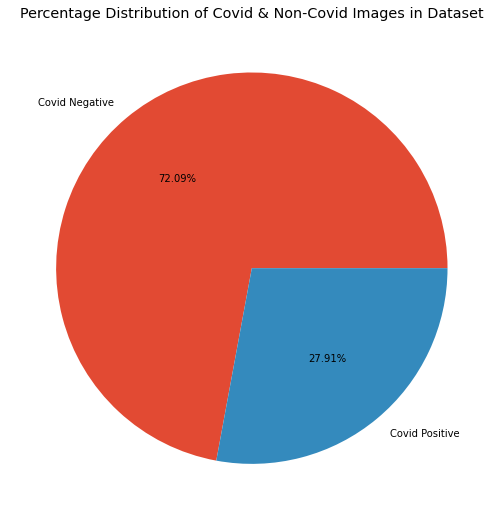

In [4]:
labels = ['Covid Negative', 'Covid Positive']
targets = [len(normal_imgs), len(covid_imgs)]
plt.figure(figsize=plt.figaspect(1))
plt.style.use("ggplot")
plt.figure(figsize=(9, 9))
plt.pie(x=targets, labels=labels, autopct="%.2f%%")
plt.title("Percentage Distribution of Covid & Non-Covid Images in Dataset")
plt.show()

# Create Model

In [5]:
dataset = covid_imgs
images = [cv2.imread(img) for img in dataset]
covid = []
for img in images:
    imgs = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    resized = cv2.resize(imgs,(224,224), interpolation = cv2.INTER_AREA)
    covid.append(resized)
covid = np.array(covid) / 255.0

In [6]:
dataset = normal_imgs 
images = [cv2.imread(img) for img in dataset]
noncovid = []
for img in images:
    imgs = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    resized = cv2.resize(imgs,(224,224), interpolation = cv2.INTER_AREA)
    noncovid.append(resized)
noncovid = np.array(noncovid) / 255.0

In [7]:
cov_labels = np.ones(covid.shape[0]) 
noncov_labels = np.zeros(noncovid.shape[0])
X = np.vstack((covid,noncovid))
y = np.hstack((cov_labels,noncov_labels))
y = to_categorical(y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
trainModel = ImageDataGenerator(rotation_range=15,fill_mode="nearest")
baseModel = VGG16(weights="imagenet", include_top = False,input_tensor=Input(shape=(224,224,3)))

In [10]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [12]:
opt = Adam(lr=1e-3, decay=1e-3 / 10)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [13]:
EPOCHS = 10
BS = 8
H = model.fit_generator(
	trainModel.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // BS,
	epochs=EPOCHS)

Epoch 1/10
24/24 [==============================] - 185s 7s/step - loss: 0.6873 - accuracy: 0.6189 - val_loss: 0.5090 - val_accuracy: 0.7077
Epoch 2/10
24/24 [==============================] - 194s 8s/step - loss: 0.5198 - accuracy: 0.7989 - val_loss: 0.4266 - val_accuracy: 0.7538
Epoch 3/10
24/24 [==============================] - 203s 9s/step - loss: 0.4125 - accuracy: 0.8008 - val_loss: 0.3400 - val_accuracy: 0.8615
Epoch 4/10
24/24 [==============================] - 205s 9s/step - loss: 0.3568 - accuracy: 0.8725 - val_loss: 0.2789 - val_accuracy: 0.9077
Epoch 5/10
24/24 [==============================] - 197s 8s/step - loss: 0.3141 - accuracy: 0.8833 - val_loss: 0.2309 - val_accuracy: 0.9538
Epoch 6/10
24/24 [==============================] - 206s 9s/step - loss: 0.2678 - accuracy: 0.8949 - val_loss: 0.1979 - val_accuracy: 0.9538
Epoch 7/10
24/24 [==============================] - 207s 9s/step - loss: 0.2685 - accuracy: 0.8741 - val_loss: 0.1777 - val_accuracy: 0.9538
Epoch 8/10
24

In [14]:
predictMod = model.predict(X_test, batch_size=BS)
prediction = np.argmax(predictMod, axis=1)

# Save Model

In [15]:
model.save(filepath='xray_covid.h5',save_format="h5")

# Load Model 

In [16]:
loading_model = tf.keras.models.load_model('xray_covid.h5')

# COVID Prediction

In [24]:
cov_predict = cv2.imread('C:/Users/Downloads/COVID19_X-Ray/Resources/Dataset/Validation/Covid/SARS1.jpeg')
imgs = cv2.cvtColor(cov_predict,cv2.COLOR_BGR2RGB)
resized = cv2.resize(imgs,(224,224), interpolation = cv2.INTER_AREA)
covid = np.array(resized) / 255.0
predicting = covid.reshape((1,224,224,3))
predictMod = loading_model.predict(predicting,batch_size=1)
prediction = np.argmax(predictMod, axis=1)
if prediction == 1:
    result = 'COVID Positive'
else:
    result = 'COVID Negative'

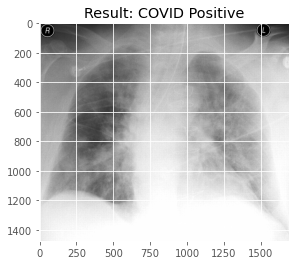

In [25]:
plt.imshow(cov_predict,'gray')
plt.title('Result: '+ str(result))
plt.show()

In [26]:
to_predict = cv2.imread('C:/Users/Downloads/COVID19_X-Ray/Resources/Dataset/Validation/Normal/NORMAL1.jpeg')
imge = cv2.cvtColor(to_predict,cv2.COLOR_BGR2RGB)
resized = cv2.resize(imge,(224,224), interpolation = cv2.INTER_AREA)
pred_img = np.array(resized) / 255.0
pred_img = pred_img.reshape((1,224,224,3))
preds = loading_model.predict(pred_img,batch_size=1)
pred = np.argmax(preds, axis=1)
if pred == 1:
    result = 'COVID Positive'
else:
    result = 'COVID Negative'

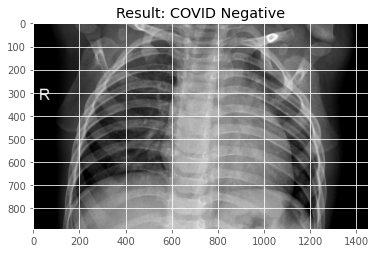

In [27]:
plt.imshow(to_predict,'gray')
plt.title('Result: '+ str(result))
plt.show()